# Проект: классификация

In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing  import LabelEncoder
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score,f1_score, precision_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from  sklearn import ensemble

import warnings
warnings.filterwarnings('ignore')


In [ ]:
def rand_rgb():
    return (np.random.random(), np.random.random(), np.random.random())

## Часть 1. Знакомство с данными, обработка пропусков и выбросов

### Задание 1

In [ ]:
df = pd.read_csv('data/bank_fin.zip', sep = ';')

In [ ]:
# на случай отката
df_copy = df.copy()

Данные о клиентах банка:

    - age (возраст);
    - job (сфера занятости);
    - marital (семейное положение);
    - education (уровень образования);
    - default (имеется ли просроченный кредит);
    - housing (имеется ли кредит на жильё);
    - loan (имеется ли кредит на личные нужды);
    - balance (баланс).

Данные, связанные с последним контактом в контексте текущей маркетинговой кампании:

    - contact (тип контакта с клиентом);
    - month (месяц, в котором был последний контакт);
    - day (день, в который был последний контакт);
    - duration (продолжительность контакта в секундах).

Прочие признаки:

    - campaign (количество контактов с этим клиентом в течение текущей кампании);
    - pdays (количество пропущенных дней с момента последней маркетинговой кампании до контакта в текущей кампании);
    - previous (количество контактов до текущей кампании)
    - poutcome (результат прошлой маркетинговой кампании).

И, разумеется, наша целевая переменная `deposit`, которая определяет, согласится ли клиент открыть депозит в банке. Именно её мы будем пытаться предсказать в данном кейсе.

In [ ]:
features = {
    'age': 'возраст',
    'job': 'сфера занятости',
    'marital': 'семейное положение',
    'education': 'уровень образования',
    'default': 'просроченный кредит',
    'housing': 'кредит на жильё',
    'loan': 'кредит на личные нужды',
    'balance': 'баланс',
    'contact': 'тип контакта с клиентом',
    'month': 'месяц, в котором был последний контакт',
    'day': 'день, в который был последний контакт',
    'duration': 'продолжительность контакта, сек.',
    'campaign': 'количество контактов с клиентом в течение текущей MK',
    'pdays': 'кол-во пропущенных дней с момента последней MK до контакта в текущей MK',
    'previous': 'количество контактов до текущей кампании',
    'poutcome': 'результат прошлой маркетинговой кампании',
    'deposit': 'депозит'
}

In [ ]:
# исследуйте данные на предмет пропусков. Где есть пропущенные значения? Сколько их?
# ваш код
#print(df.info())
print('Где есть пропущенные значения? Сколько их?\n', df.isnull().sum())


Где есть пропущенные значения? Сколько их?
 age           0
job           0
marital       0
education     0
default       0
balance      25
housing       0
loan          0
contact       0
day           0
month         0
duration      0
campaign      0
pdays         0
previous      0
poutcome      0
deposit       0
dtype: int64


### Задание 2

In [ ]:
# есть ли в признаке job пропущенные значения? Возможно, они обозначены каким-то специальным словом?
# ваш код
df.job.value_counts()

job
management       2566
blue-collar      1944
technician       1823
admin.           1334
services          923
retired           778
self-employed     405
student           360
unemployed        357
entrepreneur      328
housemaid         274
unknown            70
Name: count, dtype: int64

### Задание 3

In [ ]:

# преобразуйте признак balance таким образом, чтобы он корректно считывался, как вещественное число (float)
display(df['balance'].sample(2))
df['balance'] = df['balance'].str.replace(' ', '').str.replace('$', '').str.replace(',', '.')
df['balance'] = df['balance'].astype(float)
display(df['balance'].sample(2))
# Вычислите среднее значение по преобразованному в корректный вид признаку balance.
# Ответ округлите до трёх знаков после точки-разделителя.
df['balance'].mean().round(3)

9111        19,00 $ 
2279     1 980,00 $ 
Name: balance, dtype: object

6710    2308.0
8055     946.0
Name: balance, dtype: float64

1529.129

### Задание 4

In [ ]:
# обработайте пропуски в признаки balance , заменив их на медианные значения по данному признаку
# ваш код
median_balance = df['balance'].median()
df['balance'].fillna(median_balance, inplace=True)
df['balance'].mean().round(3)

1526.936

### Задание 5

In [ ]:
# обработайте пропуски в категориальных признаках: job и education, заменив их на модальные значения
# ваш код
mode_job = df['job'].mode()[0]
df['job'].replace('unknown', mode_job, inplace=True)

mode_education = df['education'].mode()[0]
df['education'].replace('unknown', mode_education, inplace=True)

# print(df.job.value_counts())
# print(df.education.value_counts())

# После замены пропусков рассчитайте средний баланс для клиентов с самой популярной работой
# и самым популярным уровнем образования (т. е. для тех, у кого одновременно
# самая популярная работа и самое популярное образование).
# Ответ округлите до трёх знаков после точки-разделителя.
print(df[(df['job'] == mode_job) & (df['education'] == mode_education)]['balance'].mean().round(3))


1598.883


### Задание 6

<AxesSubplot: >

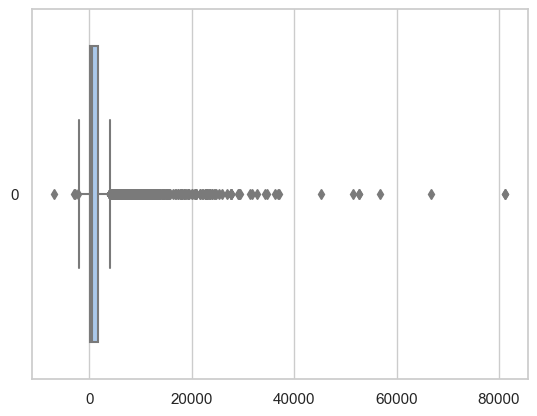

In [ ]:
sns.boxplot(df.balance, orient='h')

Нижняя граница: -2241
Верхняя граница: 4063
Размер таблицы после фильтрации по методу Тьюки:  (10105, 17)


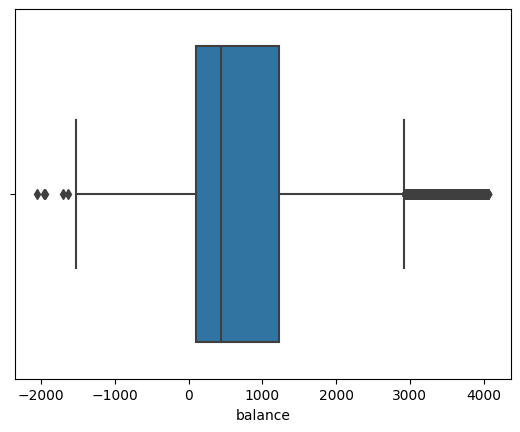

In [ ]:
# удалите все выбросы для признака balance
# ваш код
Q1 = df['balance'].quantile(0.25)
Q3 = df['balance'].quantile(0.75)
IQR = Q3 - Q1

# Верхняя и нижняя граница по методу Тьюки
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

print(f"Нижняя граница: {lower_bound:.0f}")
print(f"Верхняя граница: {upper_bound:.0f}")

# Фильтр, оставляем только значения в пределах верхней и нижней границы
df = df[(df['balance'] >= lower_bound) & (df['balance'] <= upper_bound)]

sns.boxplot(df, x='balance', orient='h')

print('Размер таблицы после фильтрации по методу Тьюки: ', df.shape)

## Часть 2:  Разведывательный анализ

In [ ]:
file_name = 'bank_fin_1.csv'
df.to_csv(f'data/{file_name}.zip', index=False, compression=dict(method='zip', archive_name=file_name))

### Задание 1

Сколько клиентов открыли депозит?  4681


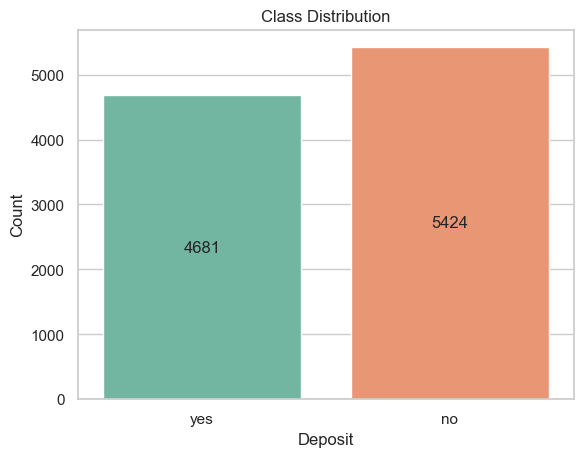

In [ ]:
# изучите соотношение классов в ваших данных на предмет несбалансированности, проиллюстрируйте результат
# ваш код

sns.set(style="whitegrid", palette="pastel")
ax = sns.countplot(data=df, x='deposit', palette="Set2")
for c in ax.containers:
        ax.bar_label(c, label_type='center')

plt.xlabel('Deposit')
plt.ylabel('Count')
plt.title('Class Distribution')

print('Сколько клиентов открыли депозит? ', len(df.query('deposit=="yes"')))

### Задания 2 и 3

,count,mean,std,min,25%,50%,75%,max,variance
age,10105.0,40.895,11.735,18.0,32.0,38.0,48.0,95.0,137.709
balance,10105.0,807.654,994.152,-2049.0,95.0,445.0,1227.0,4063.0,988338.131
day,10105.0,15.590,8.442,1.0,8.0,15.0,22.0,31.0,71.259
duration,10105.0,368.743,346.652,2.0,137.0,252.0,490.0,3881.0,120167.279
campaign,10105.0,2.517,2.707,1.0,1.0,2.0,3.0,43.0,7.329
pdays,10105.0,51.320,109.644,-1.0,-1.0,-1.0,2.0,854.0,12021.846
previous,10105.0,0.816,2.244,0.0,0.0,0.0,1.0,58.0,5.035


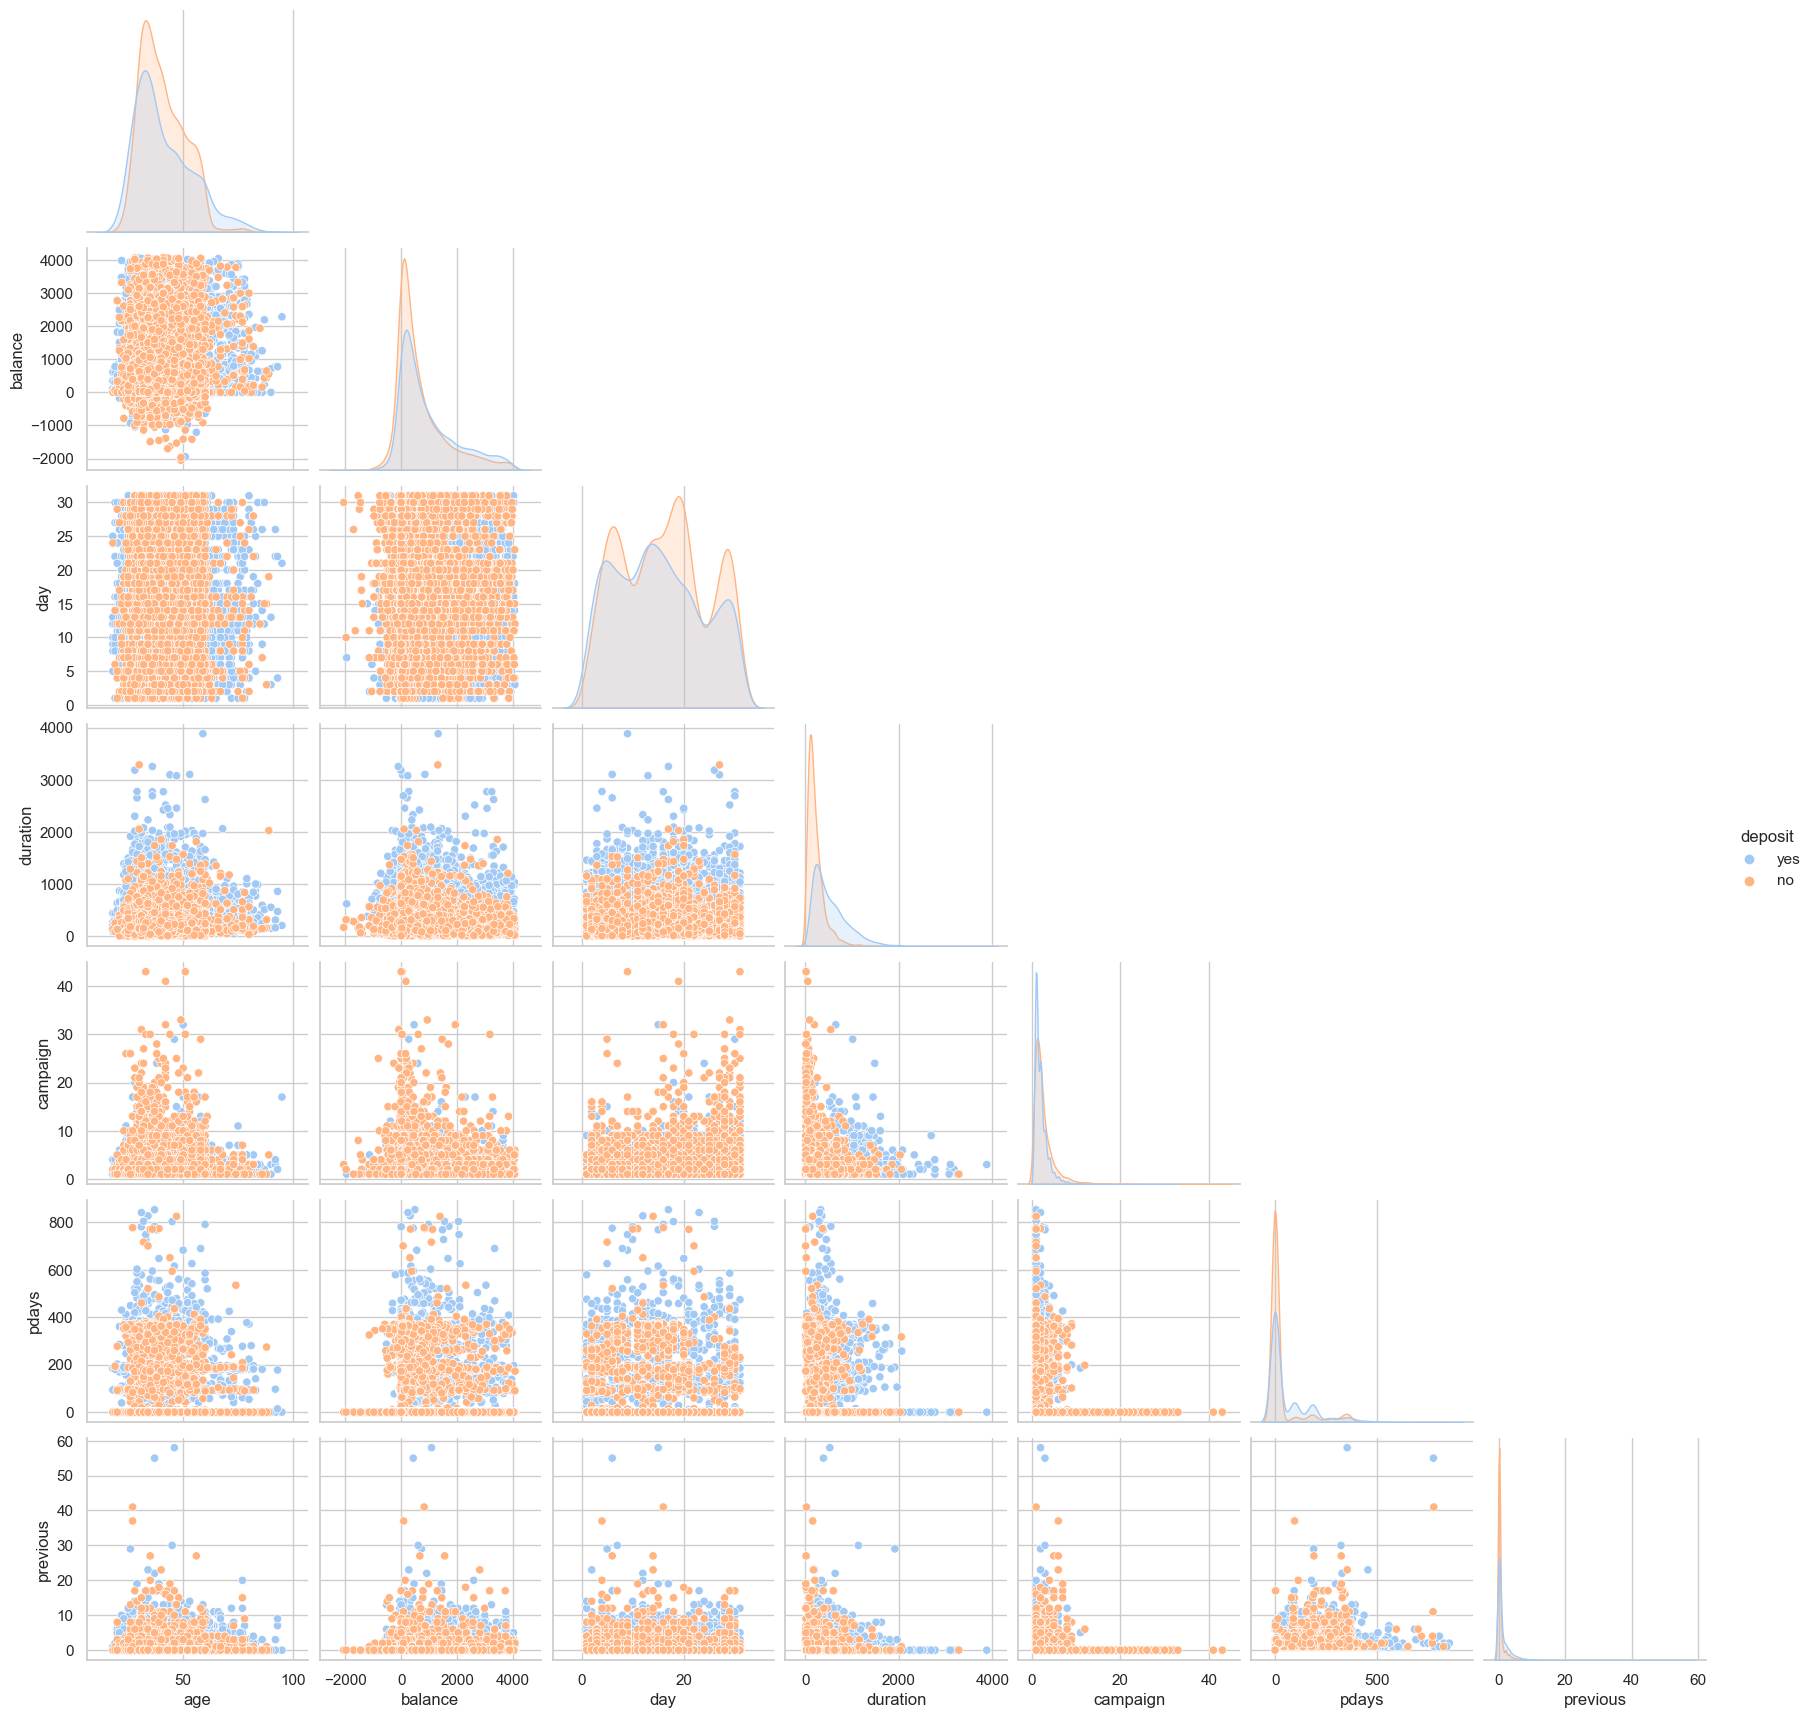

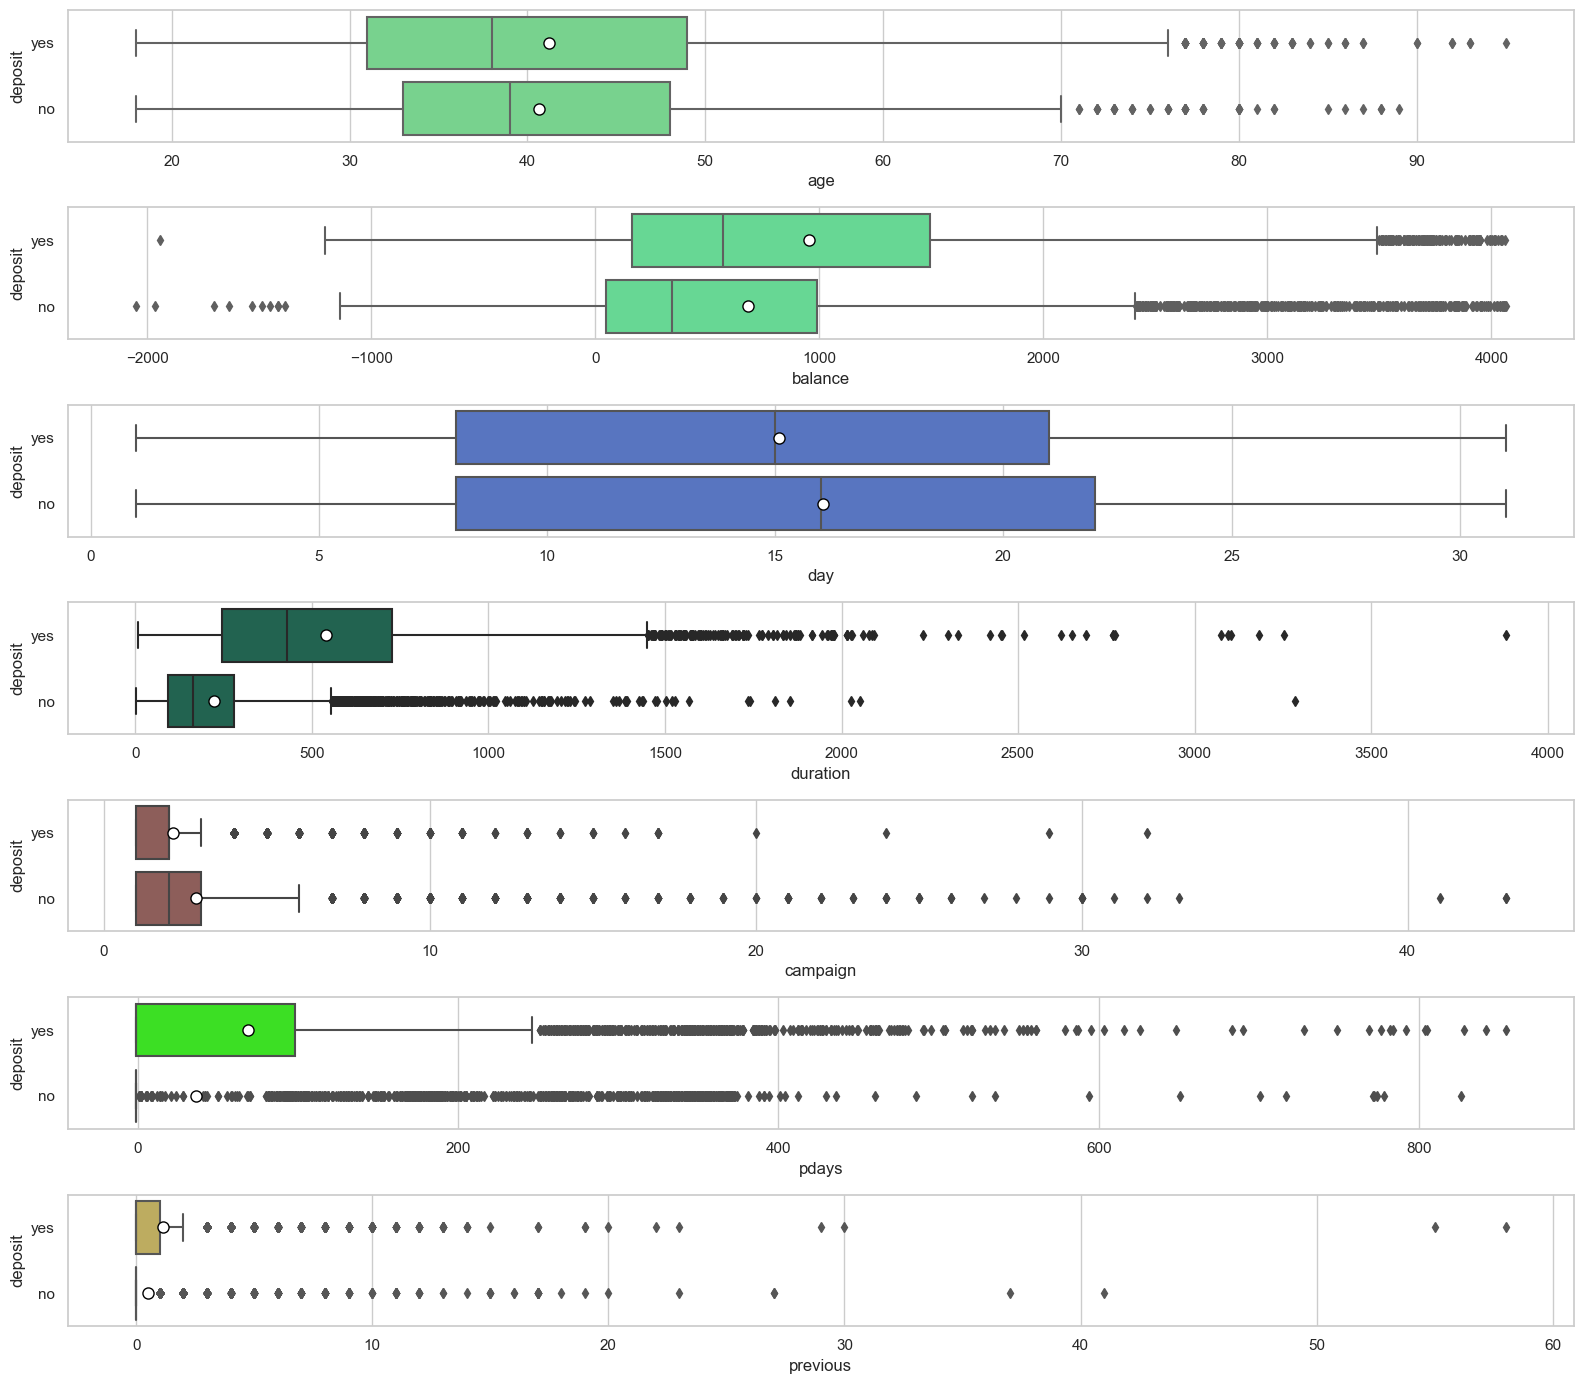

In [ ]:
#рассчитайте описательные статистики для количественных переменных, проинтерпретируйте результат
#ваш код

numerical_columns = df.select_dtypes(include=['int', 'float']).columns
description = df[numerical_columns].describe()
description.loc['variance'] = df[numerical_columns].var()
display(description.T.round(3))

sns.set_style("whitegrid")
#sns.pairplot(df, diag_kind='hist', palette='husl')
sns.pairplot(df, hue="deposit", diag_kind="kde", corner=True)
plt.show()

len_columns = len(numerical_columns)
fig, axes = plt.subplots(len_columns,1 , figsize=(16, 2 * len_columns))

for i, column in enumerate(numerical_columns):
    random_color = (np.random.random(), np.random.random(), np.random.random())
    sns.boxplot(data= df, x=column, ax=axes[i], color=random_color, y='deposit',
                showmeans=True, meanprops={'marker':'o',
                       'markerfacecolor':'white',
                       'markeredgecolor':'black',
                       'markersize':'8'})
    #axes[i].set_title(f'Box Plot for {column}')

plt.tight_layout()
plt.show()

In [ ]:
# Можно из таблицы describe посмотреть
print('Каков максимальный возраст клиента банка?', df.age.max())
# Какова минимальная продолжительность разговора с клиентом банка? Ответ дайте в количестве секунд.


Каков максимальный возраст клиента банка? 95


### Задания 4 и 5

,count,unique,top,freq
job,10105,11,management,2315
marital,10105,3,married,5715
education,10105,3,secondary,5517
default,10105,2,no,9939
housing,10105,2,no,5243
loan,10105,2,no,8712
contact,10105,3,cellular,7283
month,10105,12,may,2617
poutcome,10105,4,unknown,7570
deposit,10105,2,no,5424


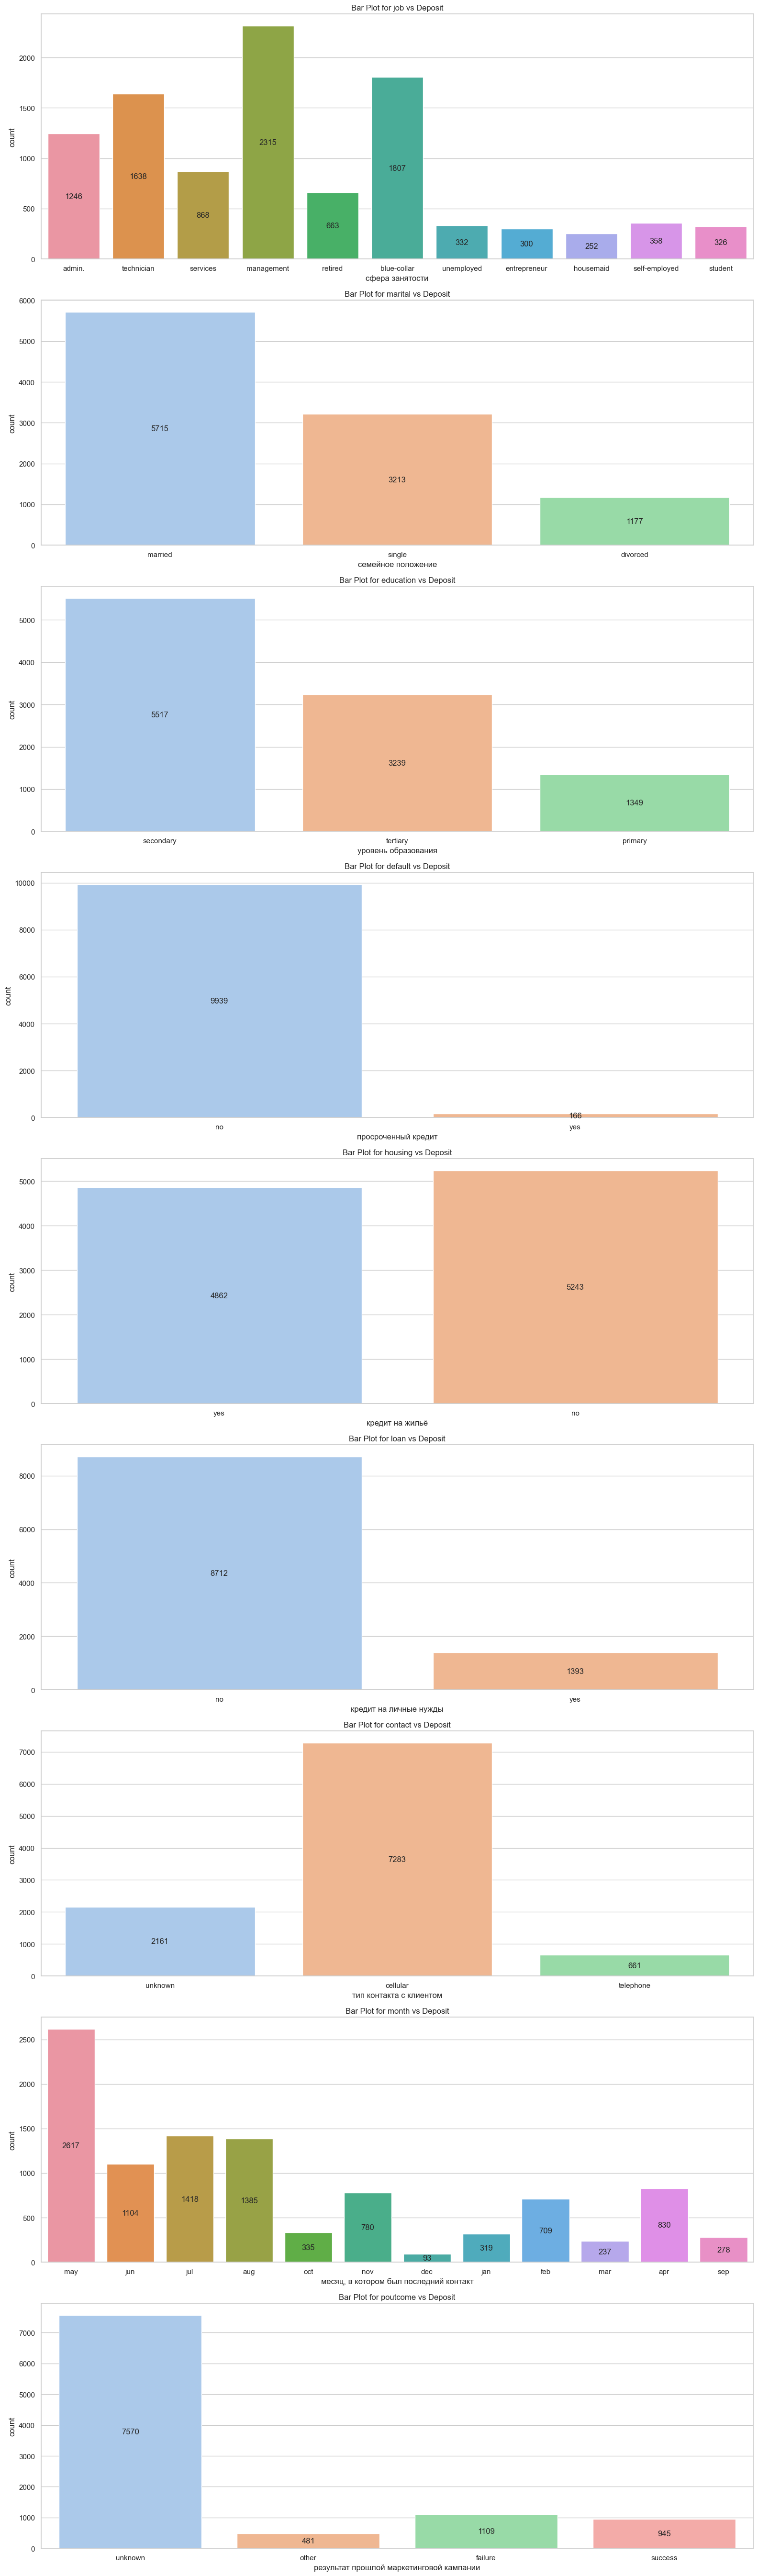

In [ ]:
#рассчитайте описательные статистики для категориальных переменных, проинтерпретируйте результат
#ваш код
#постройте визуализации, иллюстрирующие результаты

display(df.describe(include='object').T)

#df.columns[df.dtypes=='object']
categorical_columns = df.select_dtypes(include=['object']).columns[:-1]
len_columns = len(categorical_columns)
fig, axes = plt.subplots(len_columns, 1, figsize=(16, 6 * len_columns))

for i, column in enumerate(categorical_columns):
    ax = sns.countplot(data=df, x=column, ax=axes[i])
    for c in ax.containers:
        ax.bar_label(c, label_type='center')
    ax.set_title(f'Bar Plot for {column} vs Deposit')
    ax.set_xlabel(features[column])

plt.tight_layout()
plt.show()

# #Сколько было месяцев, в которых проводилась маркетинговая кампания?
# df.month.nunique()
# # Сколько сфер занятости представлено среди клиентов банка?
# df.job.nunique()
# кэп, загляни в таблицу describe

### Задание 6

Есть ли разница в результатах текущей маркетинговой кампании и предыдущей. Возможно, люди, которые уже однажды согласились на предложение банка, более склонны принять его вновь. А возможно, ситуация ровно обратная. Узнайте, для какого статуса предыдущей маркетинговой кампании успех в текущей превалирует над количеством неудач.

Cтатус предыдущей кампании с большей разницей в пользу успехов:  success


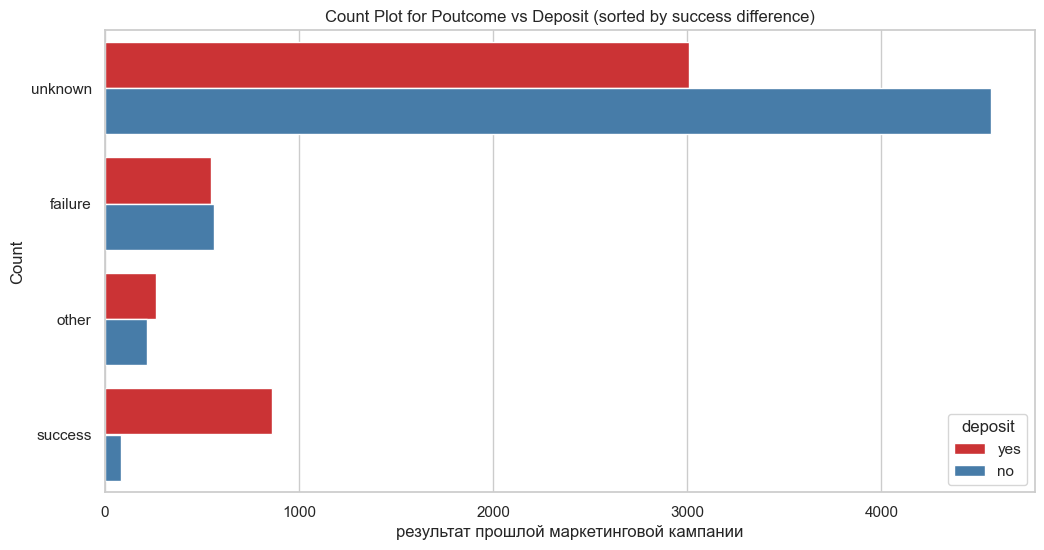

In [ ]:
# Узнайте, для какого статуса предыдущей маркетинговой кампании успех в текущей
# превалирует над количеством неудач.
# ваш код

# Группировка данных по статусу предыдущей кампании (poutcome)
poutcome_grouped = df.groupby('poutcome')['deposit'].value_counts().unstack()
poutcome_grouped['success_diff'] = poutcome_grouped['yes'] - poutcome_grouped['no']

#poutcome_grouped.plot(kind='bar',stacked = True)

print('Cтатус предыдущей кампании с большей разницей в пользу успехов: ',
                poutcome_grouped['success_diff'].idxmax())

plt.figure(figsize=(12, 6))
sns.countplot(data=df, y='poutcome', hue='deposit', orient='h', palette='Set1',
              order=poutcome_grouped['success_diff'].sort_values().index)
plt.title('Count Plot for Poutcome vs Deposit (sorted by success difference)')
plt.xlabel(features['poutcome'])
plt.ylabel('Count')
plt.show()

### Задание 7

Месяц с наибольшим количеством отказов:  may


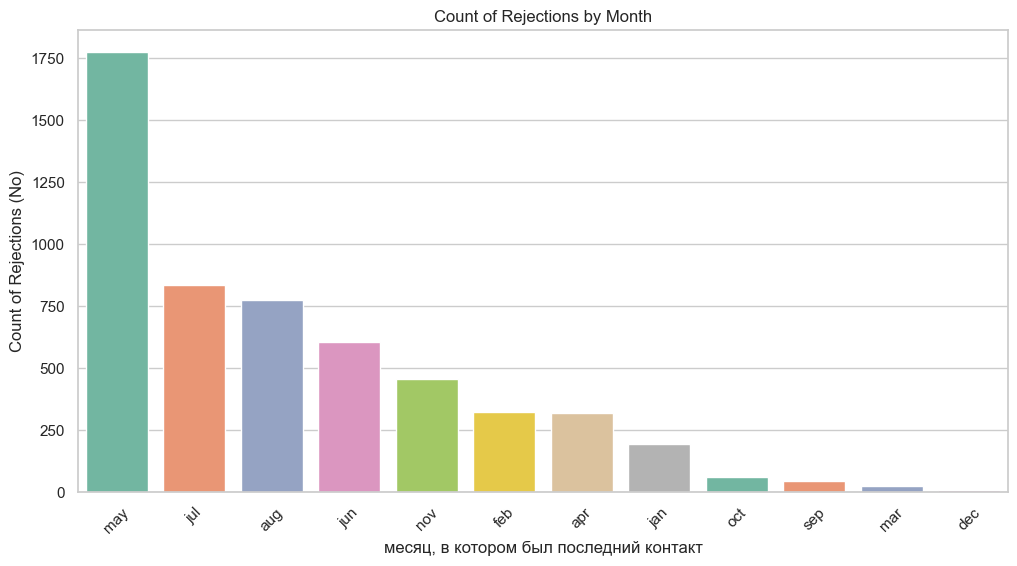

In [ ]:
# узнайте, в каком месяце чаще всего отказывались от предложения открыть депозит
# ваш код

# month_deposit_cross = pd.crosstab(df['month'], df['deposit'])
# month_no_deposit_sum = month_deposit_cross['no'].sort_values(ascending=False)
# most_rejections_month = month_no_deposit_sum.index[0]

month_no =df.query('deposit=="no"')['month'].value_counts()
print('Месяц с наибольшим количеством отказов: ', month_no.index[0])

plt.figure(figsize=(12, 6))
sns.barplot(x=month_no.index, y=month_no, palette='Set2')
plt.title('Count of Rejections by Month')
plt.xlabel(features['month'])
plt.ylabel('Count of Rejections (No)')
plt.xticks(rotation=45)
plt.show()


### Задание 8

<AxesSubplot: xlabel='age_group', ylabel='count'>

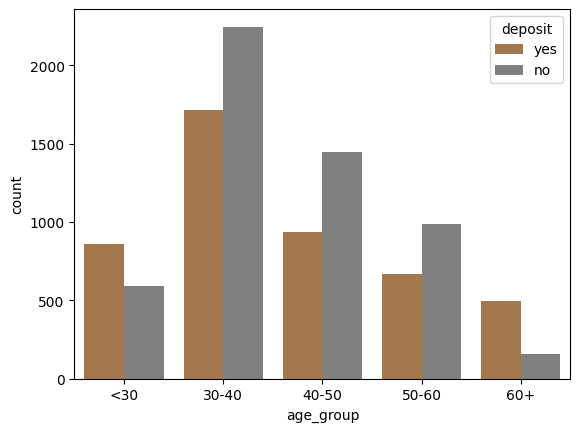

In [ ]:
# создайте возрастные группы и определите, в каких группах более склонны открывать депозит,
# чем отказываться от предложения

df['age_group'] = pd.cut(df['age']
                    , bins=[0, 30, 40, 50, 60, 9999]
                    , labels=['<30', '30-40', '40-50', '50-60', '60+']
                    , right=False)

sns.countplot(data=df, x='age_group', hue='deposit', palette=[rand_rgb(), 'gray'])



### Задания 9 и 10

<AxesSubplot: xlabel='marital', ylabel='count'>

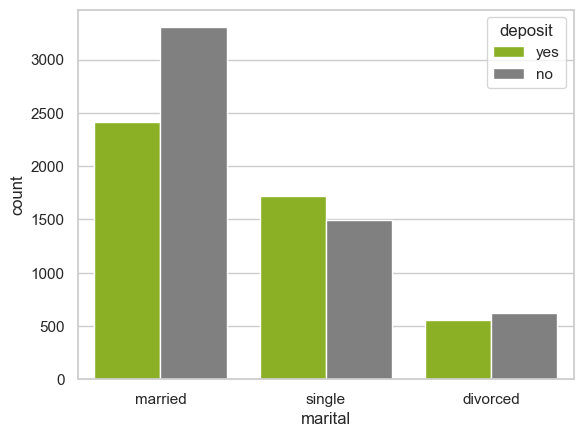

In [ ]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от семейного статуса
sns.countplot(data=df, x='marital', hue='deposit', palette=[rand_rgb(), 'gray'])

<AxesSubplot: xlabel='education', ylabel='count'>

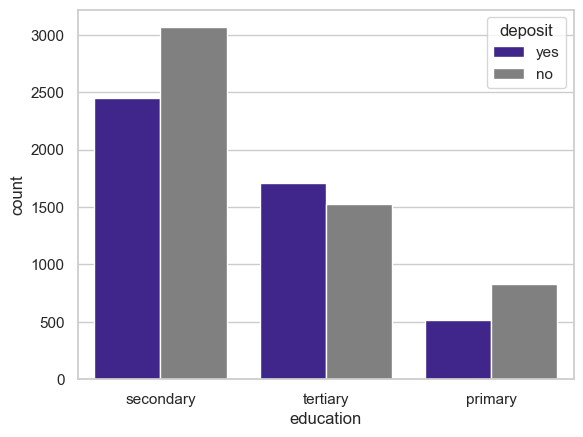

In [ ]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от образования
sns.countplot(data=df, x='education', hue='deposit', palette=[rand_rgb(), 'gray'])

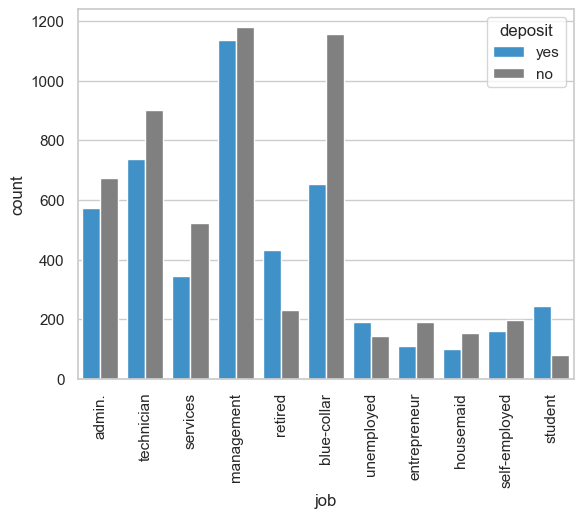

In [ ]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от вида профессиональной занятости
sns.countplot(data=df, x='job', hue='deposit', palette=[rand_rgb(), 'gray'])
plt.xticks(rotation=90)
plt.show()

### Задание 11

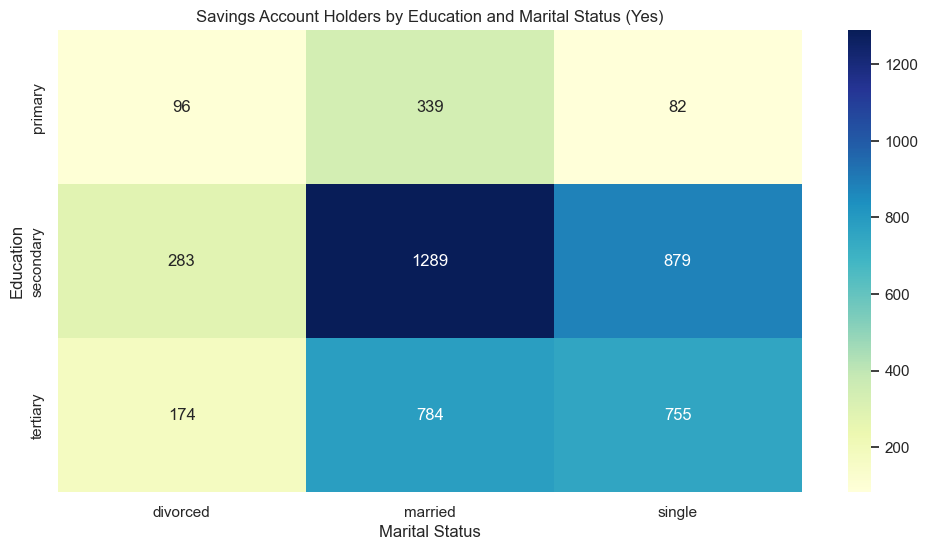

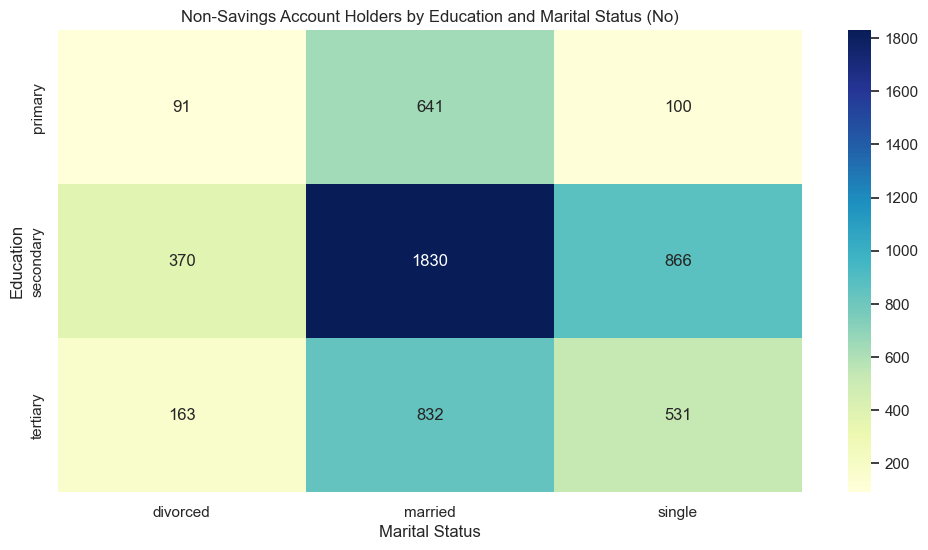

Самое многочисленное пересечение: ('secondary', 'married')


In [ ]:
# постройте сводную таблицу, чтобы определить люди с каким образованием
# и семейным статусом наиболее многочисленны
#(если рассматривать тех, кто открыл депозит)

df_deposit_yes = df[df['deposit'] == 'yes']
df_deposit_no = df[df['deposit'] == 'no']

# Сводная диаграмма для уровня образования и семейного положения среди открывших депозит
plt.figure(figsize=(12, 6))
pivot_table_yes = df_deposit_yes.pivot_table(index='education', columns='marital', values='deposit', aggfunc='count')
sns.heatmap(pivot_table_yes, annot=True, cmap='YlGnBu', fmt='.0f')
plt.title('Savings Account Holders by Education and Marital Status (Yes)')
plt.xlabel('Marital Status')
plt.ylabel('Education')
plt.show()

# Сводная диаграмма для уровня образования и семейного положения среди неоткрывших депозит
plt.figure(figsize=(12, 6))
pivot_table_no = df_deposit_no.pivot_table(index='education', columns='marital'
                        , values='deposit', aggfunc='count')
sns.heatmap(pivot_table_no, annot=True, cmap='YlGnBu', fmt='.0f')
plt.title('Non-Savings Account Holders by Education and Marital Status (No)')
plt.xlabel('Marital Status')
plt.ylabel('Education')
plt.show()

#cross_table = pd.crosstab(df_deposit_yes['education'], df_deposit_yes['marital']).idxmax()
print("Самое многочисленное пересечение:", pivot_table_yes.stack().idxmax())


## Часть 3: преобразование данных

In [ ]:
file_name = 'bank_fin_2.csv'
df.to_csv(f'data/{file_name}.zip', index=False, compression=dict(method='zip', archive_name=file_name))

### Задание 1

In [ ]:
# преобразуйте уровни образования
le = LabelEncoder()
df['education'] = le.fit_transform(df['education'])

In [ ]:
print('Найдите сумму получившихся значений для признака education?', df.education.sum())

Найдите сумму получившихся значений для признака education? 11995


### Задания 2 и 3

In [ ]:
# преобразуйте бинарные переменные в представление из нулей и единиц

#df[df.columns[df.dtypes=='object']].sample(10)
df.replace({
        'default': {'no': 0, 'yes': 1}
        ,'housing': {'no': 0, 'yes': 1}
        ,'loan': {'no': 0, 'yes': 1}
        ,'deposit': {'no': 0, 'yes': 1}
        }
        , inplace= True)
df[['default','housing','loan','deposit']].sample(5)

,default,housing,loan,deposit
1794,0,1,1,1
9510,0,1,0,0
239,0,0,0,1
6549,0,0,0,0
1331,0,0,0,1


In [ ]:
# Вычислите стандартное отклонение по преобразованной в корректный вид целевой переменной deposit.
# Ответ округлите до трёх знаков после точки-разделителя.
print(df.deposit.std().round(3))

# Вычислите среднее арифметическое для каждой из получившихся переменных ['default', 'housing', 'loan'],
# сложите три результата и в качестве ответа впишите итог,
# округлив его до трёх знаков после точки-разделителя.
print((df['default'].mean()+df.housing.mean()+df.loan.mean()).round(3))

0.499
0.635


### Задание 4
Необходимо преобразовать номинальные переменные, которые могут принимать несколько различных значений. Это следующие переменные:

- 'job';
- 'marital';
- 'contact';
- 'month';
- 'poutcome'.
  
Создайте для них dummy-переменные и добавьте их в набор данных.

In [ ]:
file_name = 'bank_fin_beforedummies.csv'
# df.to_csv(f'data/{file_name}.zip', index=False, compression=dict(method='zip', archive_name=file_name))
df = pd.read_csv(f'data/{file_name}.zip')

In [ ]:
nominal_features = ['job', 'marital', 'contact', 'month', 'poutcome']
df_dummies = pd.get_dummies(df[nominal_features]
                            #, columns=nominal_features
                            , drop_first=False
                            , dtype=int
                            )
df_dummies.shape


(10105, 33)

In [ ]:
df = df.join(df_dummies)
df.shape

(10105, 51)

In [ ]:
# Сколько теперь всего признаков в датасете, не считая целевую переменную?
# Введите ответ, посчитав уже добавленные dummy-переменные, но до удаления номинальных.
print(len(df.columns[:-1]))

50


### Задания 5 и 6

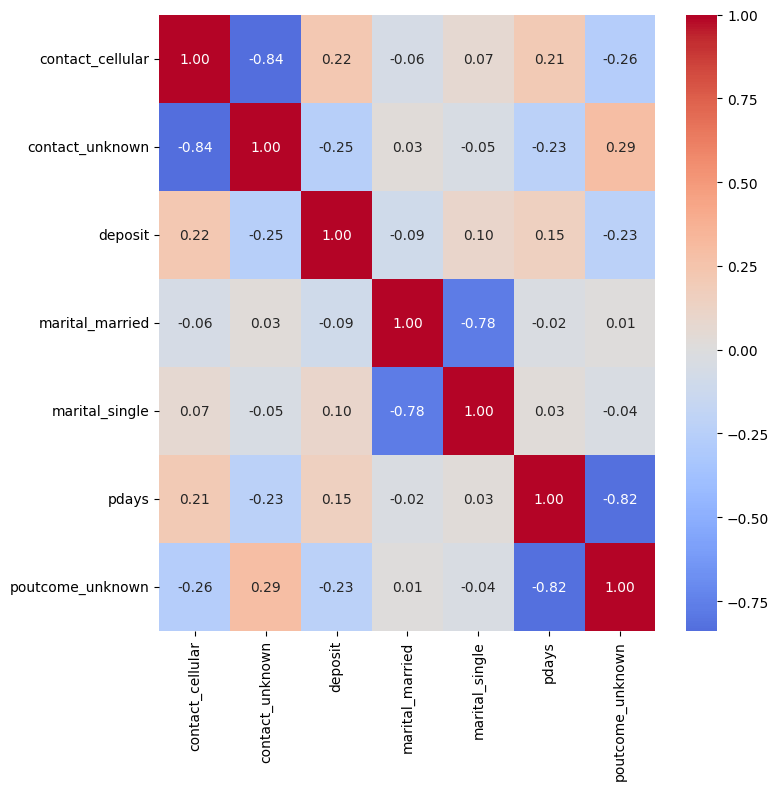

In [ ]:
# постройте корреляционную матрицу и оцените данные на предмет наличия мультиколлинеарности
corr_matrix = df.corr(numeric_only=True)
# Маска для фильтра столбцов
high_corr_mask = (abs(corr_matrix) >= 0.7) & (corr_matrix != 1.0)
high_corr_columns = corr_matrix.columns[high_corr_mask.any()]
high_corr_columns = high_corr_columns.union(['deposit'])
high_corr_matrix = corr_matrix.loc[high_corr_columns, high_corr_columns]

plt.figure(figsize=(8, 8))
sns.heatmap(high_corr_matrix, annot=True, cmap='coolwarm', center=0, fmt='.2f')
plt.show()

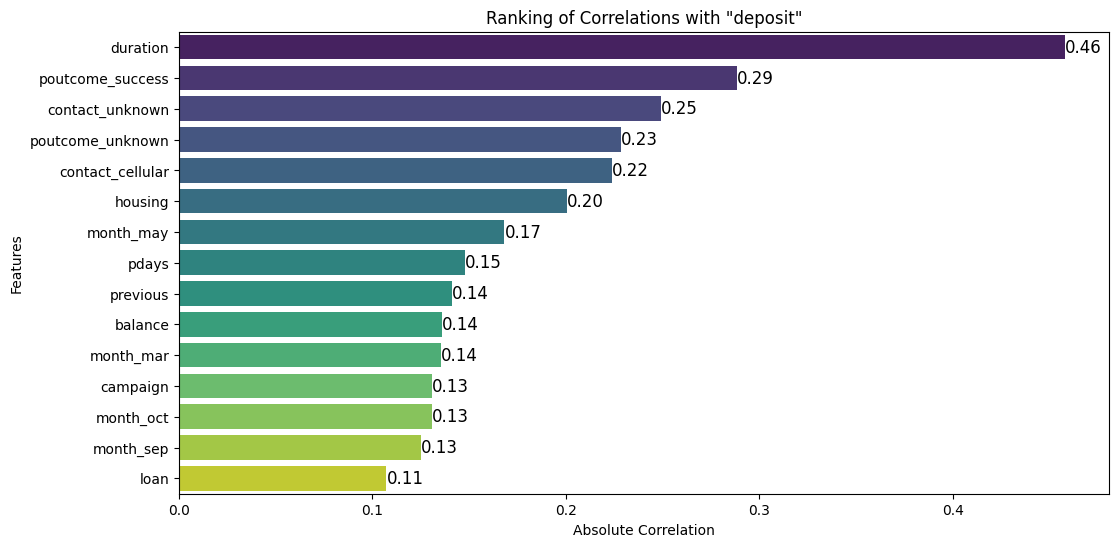

In [ ]:
# Рассчитываем корреляции и сортируем их по абсолютному значению
correlations = corr_matrix['deposit'].drop('deposit').abs().sort_values(ascending=False)[:15]

plt.figure(figsize=(12, 6))
sns.barplot(y=correlations.index, x=correlations.values, palette='viridis')
plt.title('Ranking of Correlations with "deposit"')
plt.ylabel('Features')
plt.xlabel('Absolute Correlation')

for i, val in enumerate(correlations):
    plt.text(val, i, f'{val:.2f}', va='center', fontsize=12)

plt.show()

### Задания 7 и 8

In [ ]:
label_encoder = LabelEncoder()
df['age_group'] = label_encoder.fit_transform(df['age_group'])
df['age_group'].sample()

451    1
Name: age_group, dtype: int32

In [ ]:
X, y = df.drop(['deposit'], axis=1), df['deposit']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 42, test_size = 0.33)

In [ ]:
# рассчитайте необходимые показатели
# Каким получился размер тестовой выборки?
print(X_test.shape)
#Каково среднее значение целевой переменной на тестовой выборке?
# Ответ округлите до двух знаков после точки-разделителя.
print(y_test.mean().round(2))

(3335, 50)
0.46


### Задание 9

Давайте оставим лишь те, которые сильнее всего связаны с целевой переменной и точно будут вносить вклад в повышение качества модели.

С помощью SelectKBest отберите 15 признаков, наилучшим образом подходящих для использования в задаче. Отбор реализуйте по обучающей выборке, используя параметр score_func = f_classif.

Помните, что на данном этапе вам необходимо оставить только те признаки, которые содержат лишь числовые значения.

In [ ]:
from sklearn.feature_selection import SelectKBest, f_classif

numerical_features_train = X_train.select_dtypes(exclude=['object'])

selector = SelectKBest(score_func=f_classif, k=15)
selected_features_train = selector.fit_transform(numerical_features_train, y_train)

selected_feature_names = selector.get_feature_names_out()

X_train_selected = X_train[selected_feature_names].copy()
X_test_selected = X_test[selected_feature_names].copy()

# Имена отобранных признаков
print(selected_feature_names)


['balance' 'housing' 'duration' 'campaign' 'pdays' 'previous' 'age_group'
 'contact_cellular' 'contact_unknown' 'month_mar' 'month_may' 'month_oct'
 'month_sep' 'poutcome_success' 'poutcome_unknown']


### Задание 10

Данные необходимо нормализовать. Будем использовать min-max-нормализацию.
Помните, что нормализация требуется для предикторов, а не для целевой переменной.
Нормализуйте предикторы в обучающей и тестовой выборках.

In [ ]:
# нормализуйте данные с помощью minmaxsxaler

from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train_selected)
X_test_scaled = scaler.transform(X_test_selected)

In [ ]:
# Рассчитайте среднее арифметическое для первого предиктора
# (т. е. для первого столбца матрицы) из тестовой выборки.
# Ответ округлите до двух знаков после точки-разделителя.
X_test_scaled[:,0].mean().round(2)

0.47

# Часть 4: Решение задачи классификации: логистическая регрессия и решающие деревья

### Задание 1

Алгоритм — логистическую регрессию. В качестве алгоритма оптимизации будем использовать 'sag', в качестве значения параметра random_state возьмём число 42 и запустим 1000 итераций.

Оцените качество модели на тестовой выборке.

In [ ]:
# обучите логистическую регрессию и рассчитайте метрики качества
log_reg = LogisticRegression(
    solver='sag',
    random_state=42,
    max_iter=1000).fit(X_train_scaled, y_train)

print('Test accuracy: ', accuracy_score(y_test, log_reg.predict(X_test_scaled)).round(2))

Test accuracy:  0.8


### Задания 2,3,4

Алгоритм — решающие деревья. В качестве параметров следующие:
- criterion = 'entropy',
- random_state = 42.
- Остальные параметры оставьте по умолчанию.

In [ ]:
# обучите решающие деревья, настройте максимальную глубину

dt = DecisionTreeClassifier(
    criterion='entropy',
    random_state=42
    #,max_depth = 7
    ).fit(X_train_scaled, y_train)

print('Train accuracy: ', accuracy_score(y_train, dt.predict(X_train_scaled)).round(2))
print('Test accuracy: ', accuracy_score(y_test, dt.predict(X_test_scaled)).round(2))

Train accuracy:  1.0
Test accuracy:  0.75


Переберите различные максимальные глубины деревьев и найдите глубину дерева, для которой будет максимальное значение метрики accuracy, но при этом ещё не будет наблюдаться переобучения (т. е. не будет расти качество на обучающей выборке при неизменном качестве на тестовой).

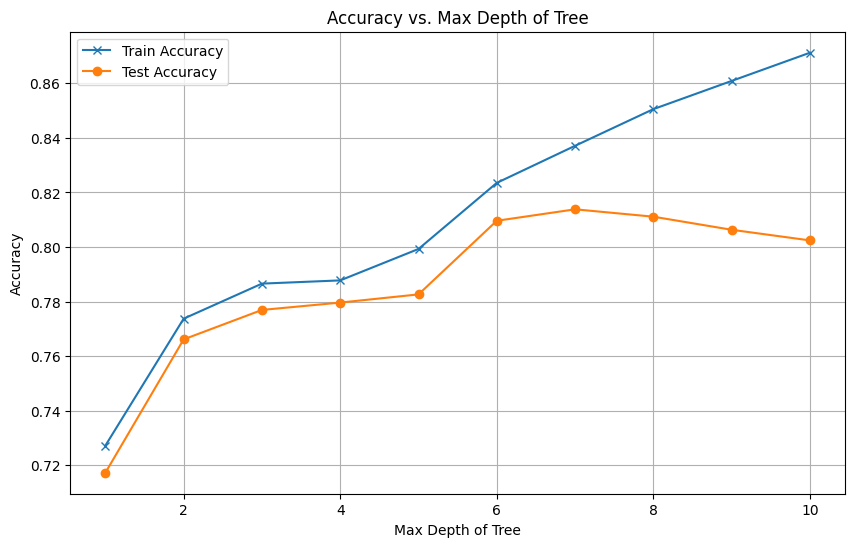

Optimal Depth: 7
Test Accuracy with Best Model: 0.81


In [ ]:
# Cписок глубин дерева
depths = range(1,11)

train_accuracies = []
test_accuracies = []

for depth in depths:
    model = DecisionTreeClassifier(max_depth=depth, random_state=42)
    model.fit(X_train_scaled, y_train)

    y_train_pred = model.predict(X_train_scaled)
    y_test_pred = model.predict(X_test_scaled)

    train_accuracies.append(accuracy_score(y_train, y_train_pred))
    test_accuracies.append(accuracy_score(y_test, y_test_pred))

# График зависимости accuracy от глубины
plt.figure(figsize=(10, 6))
plt.plot(depths, train_accuracies, label='Train Accuracy', marker='x')
plt.plot(depths, test_accuracies, label='Test Accuracy', marker='o')
plt.xlabel('Max Depth of Tree')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Max Depth of Tree')
plt.grid(True)
plt.legend()
plt.show()

best_depth = depths[test_accuracies.index(max(test_accuracies))]
print('Optimal Depth:', best_depth)
print('Test Accuracy with Best Model:', max(test_accuracies).round(2))


### Задание 5

Использовать оптимизацию: перебрать сразу большое количество комбинаций различных параметров и выбрать тот вариант, при котором модель будет давать наиболее точный прогноз.

Реализуйте оптимизацию гиперпараметров с помощью **GridSearch**, перебрав следующие параметры:
- 'min_samples_split': [2, 5, 7, 10];
- 'max_depth':[3,5,7].

Оцените метрику $F_1$ на тестовой выборке для наилучшей комбинации перебираемых параметров.

In [ ]:
# подберите оптимальные параметры с помощью gridsearch

grid_search = GridSearchCV(
        estimator=DecisionTreeClassifier(random_state=42)
        , param_grid={'min_samples_split': [2, 5, 7, 10],'max_depth':[3,5,7]}
        , scoring='f1', cv=5, return_train_score=True
)
grid_search.fit(X_train_scaled, y_train)

print("Лучшие параметры:", grid_search.best_params_)
y_pred = grid_search.best_estimator_.predict(X_test_scaled)
print(f"Метрика F1 на тестовой выборке: {f1_score(y_test, y_pred):.2f}")

Лучшие параметры: {'max_depth': 7, 'min_samples_split': 2}
Метрика F1 на тестовой выборке: 0.80


# Часть 5: Решение задачи классификации: ансамбли моделей и построение прогноза

### Задание 1

Обучите случайный лес со следующими параметрами:
- n_estimators = 100;
- criterion = 'gini';
- min_samples_leaf = 5;
- max_depth = 10;
- random_state = 42.

Оцените метрики *accuracy* и *recall* для построенной модели на тестовой выборке.

In [ ]:
# обучите на ваших данных случайный лес
from sklearn.metrics import recall_score

rf = ensemble.RandomForestClassifier(
        n_estimators=100,
        criterion='gini',
        min_samples_leaf=5,
        max_depth=10,
        random_state=42
    ).fit(X_train_scaled, y_train)

y_pred = rf.predict(X_test_scaled)
print(f"Метрика accuracy на тестовой выборке: {accuracy_score(y_test, y_pred):.3f}")
print(f"Метрика recall на тестовой выборке: {recall_score(y_test, y_pred):.3f}")

Метрика accuracy на тестовой выборке: 0.828
Метрика recall на тестовой выборке: 0.835


### Задания 2 и 3

Предлагаем вам сравнить полученные результаты с моделью градиентного бустинга. Используйте **градиентный бустинг** для решения задачи классификации, задав для него следующие параметры:
- learning_rate = 0.05;
- n_estimators = 300;
- min_samples_leaf = 5;
- max_depth = 5;
- random_state = 42.

Для построенной модели оцените метрику $F_1$ на тестовой выборке.

In [ ]:
# используйте для классификации градиентный бустинг и сравните качество со случайным лесом
gb = ensemble.GradientBoostingClassifier(
        learning_rate=0.05,
        n_estimators=300,
        min_samples_leaf=5,
        max_depth=5,
        random_state=42
    ).fit(X_train_scaled, y_train)

y_pred = gb.predict(X_test_scaled)
print(f"Метрика F1 на тестовой выборке: {f1_score(y_test, y_pred):.2f}")

Метрика F1 на тестовой выборке: 0.82


### Задание 4
Построить ансамбль из моделей разного типа. Необходимо использовать стекинг, объединив те алгоритмы, которые вы уже использовали ранее: решающие деревья, логистическую регрессию и градиентный бустинг. В качестве метамодели используйте модель логистической регрессии. Параметры оставьте те же, что были в ваших алгоритмах в предыдущих заданиях.

Для построенной модели оцените метрику precision на тестовой выборке.

In [ ]:
# объедините уже известные вам алгоритмы с помощью стекинга

clf1 = ('dt', DecisionTreeClassifier(
            criterion='entropy',
            min_samples_leaf=5,
            max_depth=7,
            random_state=42
        ))
clf2 = ('log_reg', LogisticRegression(
                solver='sag',
                random_state=42,
                max_iter=1000
        ))
clf3 = ('gb', ensemble.GradientBoostingClassifier(
            learning_rate=0.05,
            n_estimators=300,
            min_samples_leaf=5,
            max_depth=5,
            random_state=42
        ))

stack = ensemble.StackingClassifier(
    estimators=[clf1, clf2, clf3],
    final_estimator=LogisticRegression(random_state=42)
)

stack.fit(X_train_scaled, y_train)
y_pred = stack.predict(X_test_scaled)
print(f"Метрика precision на тестовой выборке: {precision_score(y_test, y_pred):.2f}")



Метрика F1 на тестовой выборке: 0.81


In [ ]:
from sklearn import model_selection

print('3-fold cross validation:\n')

for clf, label in zip([clf1, clf2, clf3, stack],
                      ['DecisionTreeClassifier',
                       'LogisticRegression',
                       'GradientBoostingClassifier',
                       'StackingClassifier']):

    scores = model_selection.cross_val_score(clf, X, y, cv=3, scoring='accuracy')
    print("Accuracy: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), label))

### Задание 5

Не все признаки одинаково хорошо предсказывают результат маркетинговой кампании. Для того чтобы отобрать наиболее значимые для нас аспекты, на которые надо будет обратить внимание при реализации следующей акции, давайте выберем три признака, дающих наибольший вклад.

Почему, с вашей точки зрения, именно эти три признака имеют наибольшую важность?

In [ ]:
# оцените, какие признаки демонстрируют наибольшую  важность в модели градиентного бустинга

# gb = ensemble.GradientBoostingClassifier()
# gb.fit(X_train_scaled, y_train)

feature_importance_df = pd.DataFrame({'Feature': X_train_selected.columns
                                      , 'Importance': gb.feature_importances_})

feature_importance_df.sort_values(by='Importance', ascending=False).head(3)


,Feature,Importance
2,duration,0.501987
13,poutcome_success,0.116264
8,contact_unknown,0.073762


### Задания 6,7,8

Фреймворк Optuna. Примените для оптимизации гиперпараметров. Для перебора возьмите случайный лес и следующие параметры:
- n_estimators = trial.suggest_int('n_estimators', 100, 200, 1);
- max_depth = trial.suggest_int('max_depth', 10, 30, 1);
- min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 10, 1).
  
Введите значение метрики $F_1$ и *accuracy* на тестовой выборке.

In [ ]:
import optuna

#print("Версия Optuna: ", optuna.__version__)

param_distributions = {
    'n_estimators': optuna.distributions.IntDistribution(100, 200),
    'max_depth': optuna.distributions.IntDistribution(10, 30),
    'min_samples_leaf': optuna.distributions.IntDistribution(2, 10),
}

optuna_search = optuna.integration.OptunaSearchCV(
        estimator = ensemble.RandomForestClassifier(random_state=42)
        , param_distributions = param_distributions
        , n_trials = 10
        , scoring='f1'
        , random_state=42
        )
optuna_search.fit(X_train_scaled, y_train)

y_pred = optuna_search.best_estimator_.predict(X_test_scaled)
print(f"Метрика f1 на тестовой выборке: {f1_score(y_test, y_pred):.2f}")

[I 2023-09-24 02:43:14,252] A new study created in memory with name: no-name-bcea4c54-ebb6-453e-a926-39572a1531e7
[I 2023-09-24 02:43:22,826] Trial 0 finished with value: 0.826132049951438 and parameters: {'n_estimators': 145, 'max_depth': 27, 'min_samples_leaf': 2}. Best is trial 0 with value: 0.826132049951438.
[I 2023-09-24 02:43:28,976] Trial 1 finished with value: 0.8253744493387603 and parameters: {'n_estimators': 132, 'max_depth': 20, 'min_samples_leaf': 4}. Best is trial 0 with value: 0.826132049951438.
[I 2023-09-24 02:43:34,926] Trial 2 finished with value: 0.8300618681325733 and parameters: {'n_estimators': 121, 'max_depth': 13, 'min_samples_leaf': 3}. Best is trial 2 with value: 0.8300618681325733.
[I 2023-09-24 02:43:40,405] Trial 3 finished with value: 0.821181053358275 and parameters: {'n_estimators': 132, 'max_depth': 17, 'min_samples_leaf': 10}. Best is trial 2 with value: 0.8300618681325733.
[I 2023-09-24 02:43:47,389] Trial 4 finished with value: 0.8257131221840573 a

Метрика f1 на тестовой выборке: 0.82


In [ ]:
# Введите значение метрики accuracy на тестовой выборке.
# Ответ округлите до двух знаков после точки-разделителя.
print(f"Метрика accuracy на тестовой выборке: {accuracy_score(y_test, y_pred):.3f}")

Метрика accuracy на тестовой выборке: 0.826
